In [1]:
import json
import copy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
!pwd

/mmdetection/demo


In [3]:
data_dir = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/new_total_mermimen_coco.json'

total_data = json.load(open(data_dir))

In [4]:
print(total_data.keys())

dict_keys(['info', 'licences', 'images', 'annotations', 'categories'])


In [5]:
print(total_data['categories'])

[{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}, {'supercategory': 'Carparts', 'id': 1, 'name': 'dent'}, {'supercategory': 'Carparts', 'id': 2, 'name': 'crack'}, {'supercategory': 'Carparts', 'id': 3, 'name': 'totaled'}]


In [6]:
print(type(total_data['annotations']))

<class 'list'>


In [7]:
scratch_anns= []
scratch_img_id = []

dent_anns = []
dent_img_id = []

crack_anns = []
crack_img_id = []

totaled_anns = []
totaled_img_id = []

for ann in total_data['annotations']:
    if ann['category_id'] == 0:
        scratch_anns.append(ann)
        scratch_img_id.append(ann['image_id'])
    elif ann['category_id'] == 1:
        dent_anns.append(ann)
        dent_img_id.append(ann['image_id'])

    elif ann['category_id'] == 2:
        crack_anns.append(ann)
        crack_img_id.append(ann['image_id'])
    else:
        totaled_anns.append(ann)
        totaled_img_id.append(ann['image_id'])

In [8]:
print(len(scratch_img_id), len(dent_img_id), len(crack_img_id), len(totaled_img_id))
print(len(scratch_anns), len(dent_anns), len(crack_anns), len(totaled_anns))

85476 79499 49384 46356
85476 79499 49384 46356


In [11]:
print(len(set(scratch_img_id)), len(set(dent_img_id)), len(set(crack_img_id)), len(set(totaled_img_id)))
# print(len(set(scratch_anns)), len(set(dent_anns)), len(set(crack_anns)), len(set(totaled_anns)))

42357 52525 30069 34102


In [16]:
25/46356*100


0.06618111676477435

In [9]:
scratch_img_id = set(scratch_img_id) - set(totaled_img_id)
dent_img_id = set(dent_img_id) - set(totaled_img_id)
crack_img_id = set(crack_img_id)
totaled_img_id = set(totaled_img_id)

print(len(scratch_img_id), len(dent_img_id), len(crack_img_id), len(totaled_img_id))
print(len(scratch_anns), len(dent_anns), len(crack_anns), len(totaled_anns))

28999 34673 30069 34102
85476 79499 49384 46356


In [12]:
85476-56450

29026

In [11]:
new_scratch_anns = []
for ann in scratch_anns:
    if ann['image_id'] in scratch_img_id:
        new_scratch_anns.append(ann)
        
new_dent_anns = []        
for ann in dent_anns:
    if ann['image_id'] in dent_img_id:
        new_dent_anns.append(ann)
print(len(scratch_img_id), len(dent_img_id), len(crack_img_id), len(totaled_img_id))
print(len(new_scratch_anns), len(new_dent_anns), len(crack_anns), len(totaled_anns))

28999 34673 30069 34102
56450 49199 49384 46356


In [13]:
scratch_json = copy.deepcopy(total_data)
scratch_json['annotations'] = new_scratch_anns
scratch_json['images'] = [img for img in scratch_json['images'] if img['id'] in scratch_img_id]

dent_json = copy.deepcopy(total_data)
dent_json['annotations'] = new_dent_anns
dent_json['images'] = [img for img in dent_json['images'] if img['id'] in dent_img_id]

crack_json = copy.deepcopy(total_data)
crack_json['annotations'] = crack_anns
crack_json['images'] = [img for img in crack_json['images'] if img['id'] in crack_img_id]

totaled_json = copy.deepcopy(total_data)
totaled_json['annotations'] = totaled_anns
totaled_json['images'] = [img for img in totaled_json['images'] if img['id'] in totaled_img_id]

In [18]:
#double check 
draft_img_id = []
draft_img_in_ann_id = []
for img in dent_json['images']:
    draft_img_id.append(img['id'])
for ann in dent_json['annotations']:
    draft_img_in_ann_id.append(ann['image_id'])

def common_member(a, b):   
    a_set = set(a)
    b_set = set(b)
     
    # check length
    if len(a_set.intersection(b_set)) > 0:
        return(a_set.intersection(b_set)) 
    else:
        return("no common elements")
print(len(common_member(draft_img_id,draft_img_in_ann_id)))
print(len(set(draft_img_id)))
print(len(set(draft_img_in_ann_id)))

34673
34673
34673


In [14]:
class features:
    def __init__(self, data=None):
        self.box_area, self.box_image_ratio, self.image_id = dict(), dict(),dict()
        self.dataset = data
        self.compute_features()
        
    def compute_features(self):
        box_area = {}
        box_image_ratio = {}
        image_id = {}
        for ann in self.dataset['annotations']:
            box_area[ann['id']] = ann['bbox'][2] * ann['bbox'][3] if ann['bbox'][2] * ann['bbox'][3] > 0 else 1e-5
            image_id[ann['id']] = ann['image_id']
            for img in self.dataset['images']:
                if ann['image_id'] == img['id']:
                    img_area = img['width'] * img['height']
                    break
    
            box_image_ratio[ann['id']] = box_area[ann['id']]/img_area
        self.box_area = box_area
        self.box_image_ratio = box_image_ratio
        self.image_id = image_id
        

In [114]:
def draw_samples(df,json_file, num=3):
    
    samples = df.sample(n=num**2)
    print(samples.shape)
    fig, axis = plt.subplots(num, num, figsize=(15,15))
    for i in range(samples.shape[0]):
        sample = samples.iloc[i,]
        annoId = sample.annotation_id
        box_area = sample.box_area
        box_image_ratio = sample.box_image_ratio

#         print('annoId', annoId, '     area:', dentbox_area, '    ratio', dentbox_image_ratio)
        
        #get image id
        for ann in json_file['annotations']:
            if ann['id'] == annoId:
                imgId = ann['image_id']
                bbox = ann['bbox']
                seg = [bbox[0],bbox[1], bbox[0]+bbox[2],bbox[1], bbox[0]+bbox[2],bbox[1]+bbox[3], bbox[0],bbox[1]+bbox[3]]
                break
        #get image name
        for img in json_file['images']:
            if img['id'] == imgId:
                image = img
                img_name = img['file_name']
                break
        img_dir = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/images'
        path = os.path.join(img_dir, img_name)
        if os.path.isfile(path):
            I = cv2.imread(path)
            seg = np.array(seg).reshape(-1,1,2)        
            shape = I.copy()
            cv2.drawContours(shape, [seg.astype(int)], -1, (0,255,0), 4)

            axis[int(i/num), i%num].imshow(shape)

# filtering test set for scratch damage

In [15]:
scratch_features = features(scratch_json)

In [ ]:
scratch_df = pd.DataFrame({'annotation_id': scratch_features.box_area.keys(),
                           'image_id':scratch_features.image_id.values(),
                          'box_area': scratch_features.box_area.values(),
                          'box_image_ratio': scratch_features.box_image_ratio.values()})

scratch_df.to_csv('statistical_charts/scatch_df.csv', index=False)

In [75]:
scratch_df = pd.read_csv('statistical_charts/scatch_df.csv')
scratch_df

annotation_id  image_id      box_area  box_image_ratio
0                 29         7    325.000048         0.001058
1                 31         7    181.749946         0.000592
2                 32         7  13173.428876         0.042882
3                 35         9   2659.937984         0.008659
4                 36        11  29447.732311         0.095859
...              ...       ...           ...              ...
56445         260706     84981    205.233405         0.000668
56446         260709     84982    368.881977         0.001201
56447         260710     84982   1347.486230         0.004386
56448         260713     84985   1482.000000         0.004824
56449         260714     84985    270.000000         0.000879

[56450 rows x 4 columns]

ratio mean  0.029369506965755483     std  0.08044105273913381
ratio max  0.996357421875      ratio min  2.0833333333333336e-11


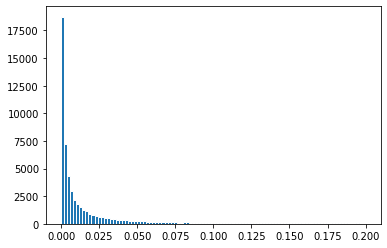

In [116]:
plt.hist(scratch_df[scratch_df.box_image_ratio<0.2].box_image_ratio, 100, edgecolor='w')
ratio_mean = scratch_df.box_image_ratio.mean()
ratio_std = scratch_df.box_image_ratio.std()
ratio_min = scratch_df.box_image_ratio.min()
ratio_max = scratch_df.box_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

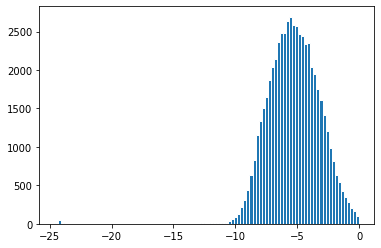

In [77]:
log_ratio = np.log(scratch_df.box_image_ratio)
plt.hist(log_ratio,100,edgecolor='w')
print('')

In [117]:
upper_coefficient = (0.1-ratio_mean)/ratio_std

upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = np.exp(-8.5)
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

clean_data = scratch_df[(scratch_df.box_image_ratio>lower_limit) & (scratch_df.box_image_ratio<upper_limit)]
under_lower_ratio_outliers = scratch_df[(scratch_df.box_image_ratio<=lower_limit)]
above_upper_ratio_outliers = scratch_df[(scratch_df.box_image_ratio>=upper_limit)]

no_outliers = scratch_df.shape[0]-clean_data.shape[0]
print('shape of clean data frame: ', clean_data.shape, '<=>  remove {} outliers'.format(no_outliers))
print('number of lower outliers', under_lower_ratio_outliers.shape[0])

print('number of upper outliers', above_upper_ratio_outliers.shape[0])
print('-----')
print('precentage of total outliers: {:.3f} % annotations'.format((no_outliers/scratch_df.shape[0])*100))
print('precentage of tiny outliers: {:.3f} % annotations'.format((under_lower_ratio_outliers.shape[0]/scratch_df.shape[0])*100))
print('precentage of huge outliers: {:.3f} % annotations <=> remove {:.3f}% images'.format((above_upper_ratio_outliers.shape[0]/scratch_df.shape[0])*100,(above_upper_ratio_outliers.shape[0]/len(scratch_json['images']))*100) )

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


upper_limit 0.1
lower_limit 0.00020346836901064417
shape of clean data frame:  (50206, 4) <=>  remove 6244 outliers
number of lower outliers 2400
number of upper outliers 3844
-----
precentage of total outliers: 11.061 % annotations
precentage of tiny outliers: 4.252 % annotations
precentage of huge outliers: 6.810 % annotations <=> remove 13.256% images


(9, 4)


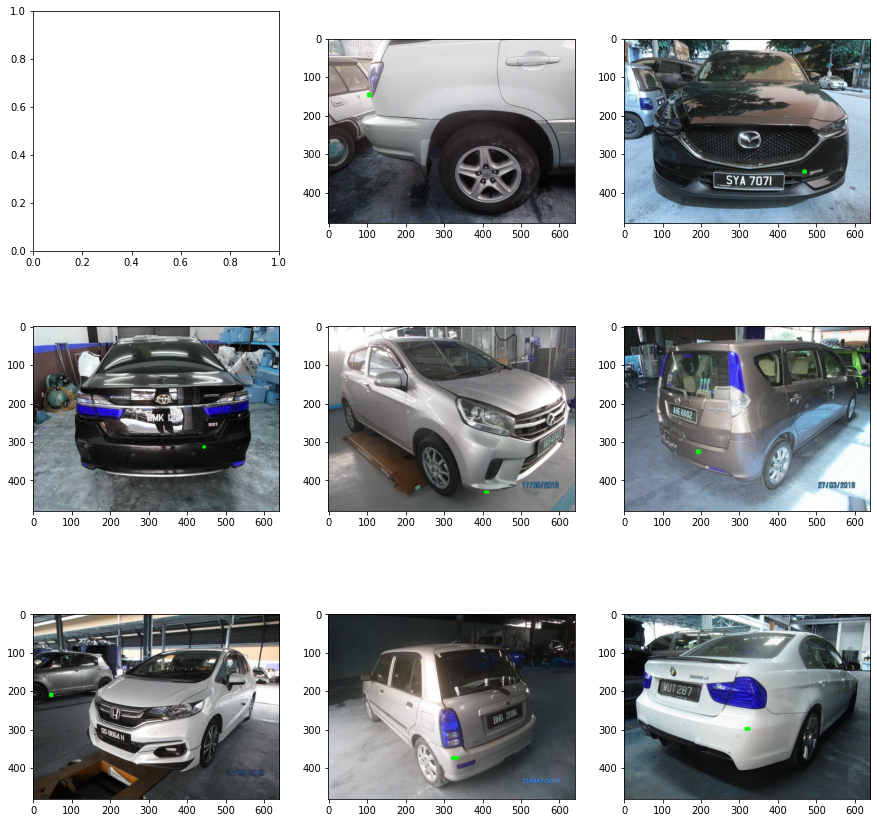

In [118]:
draw_samples(under_lower_ratio_outliers,scratch_json, num=3)

(9, 4)


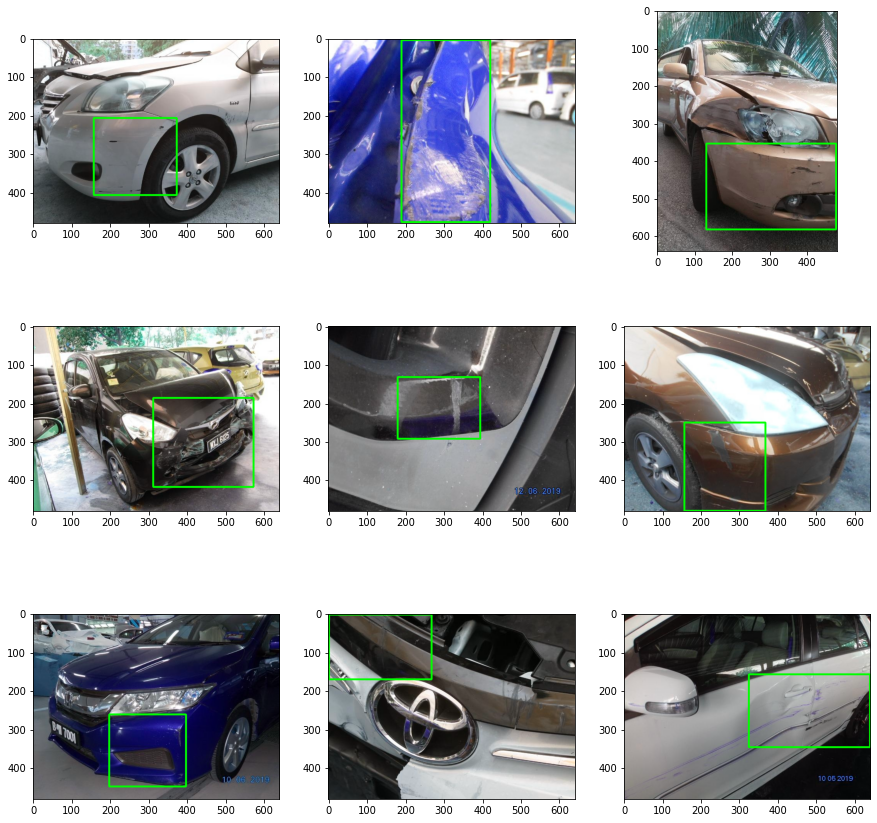

In [119]:
draw_samples(above_upper_ratio_outliers,scratch_json, num=3)

### clean data

In [25]:
removed_ann_id = list(under_lower_ratio_outliers.annotation_id)
removed_img_id = list(set(above_upper_ratio_outliers.image_id))

print(len(removed_ann_id), len(removed_img_id))

2400 3584


In [26]:
new_json = copy.deepcopy(scratch_json)

for ann in scratch_json['annotations']:
    if ann['image_id'] in removed_img_id:
        removed_ann_id.append(ann['id'])

new_json['images'] = [img for img in scratch_json['images'] if img['id'] not in removed_img_id]
new_json['annotations'] = [ann for ann in scratch_json['annotations'] if ann['id'] not in removed_ann_id]
print(len(new_json['images']), len(new_json['annotations']))

path = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/clean_scratch_annotations.json'

with open(path, 'w', encoding='utf-8') as json_file:
    json.dump(new_json, json_file, ensure_ascii=False, indent=4)

25415 47802


# filtering test set for dent damage

In [ ]:
dent_features = features(dent_json)

In [88]:
dent_df = pd.DataFrame({'annotation_id': dent_features.box_area.keys(),
                        'image_id':dent_features.image_id.values(),
                        'box_area': dent_features.box_area.values(),
                        'box_image_ratio': dent_features.box_image_ratio.values()})

dent_df.to_csv('statistical_charts/dent_df.csv', index=False)

In [89]:
dent_df = pd.read_csv('statistical_charts/dent_df.csv')
dent_df

annotation_id  image_id      box_area  box_image_ratio
0                 30         7  14016.999991         0.045628
1                 33         7   6787.039410         0.022093
2                 34         8  10294.091702         0.050264
3                 39        12   7717.107291         0.025121
4                 50        17   1862.839574         0.006064
...              ...       ...           ...              ...
49194         260699     84980   5629.192059         0.018324
49195         260707     84981  21648.126167         0.070469
49196         260708     84981  82797.019363         0.269522
49197         260711     84983  10121.738380         0.032948
49198         260712     84985  19496.999472         0.063467

[49199 rows x 4 columns]

ratio mean  0.06895688941844337     std  0.11776567323821202
ratio max  0.9956640625      ratio min  3.2552083333333334e-11


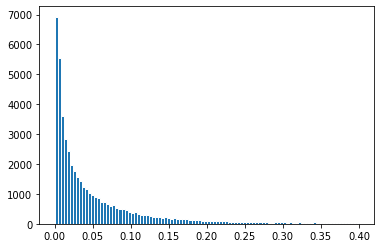

In [154]:
plt.hist(dent_df[dent_df.box_image_ratio<0.4].box_image_ratio, 100, edgecolor='w')
ratio_mean = dent_df.box_image_ratio.mean()
ratio_std = dent_df.box_image_ratio.std()
ratio_min = dent_df.box_image_ratio.min()
ratio_max = dent_df.box_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

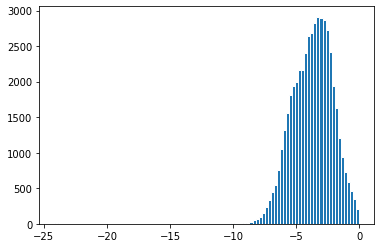

In [121]:
log_ratio = np.log(dent_df.box_image_ratio)
plt.hist(log_ratio,100,edgecolor='w')
print('')

In [155]:
upper_coefficient = (1-ratio_mean)/ratio_std

upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = np.exp(-7.5)
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

clean_data = dent_df[(dent_df.box_image_ratio>lower_limit) & (dent_df.box_image_ratio<upper_limit)]
under_lower_ratio_outliers = dent_df[(dent_df.box_image_ratio<=lower_limit)]
above_upper_ratio_outliers = dent_df[(dent_df.box_image_ratio>=upper_limit)]

no_outliers = dent_df.shape[0]-clean_data.shape[0]
print('shape of clean data frame: ', clean_data.shape, '<=>  remove {} outliers'.format(no_outliers))
print('number of lower outliers', under_lower_ratio_outliers.shape[0])

print('number of upper outliers', above_upper_ratio_outliers.shape[0])
print('-----')
print('precentage of total outliers: {:.3f} % annotations'.format((no_outliers/dent_df.shape[0])*100))
print('precentage of tiny outliers: {:.3f} % annotations'.format((under_lower_ratio_outliers.shape[0]/dent_df.shape[0])*100))
print('precentage of huge outliers: {:.3f} % annotations <=> remove {:.3f}% images'.format((above_upper_ratio_outliers.shape[0]/dent_df.shape[0])*100,(above_upper_ratio_outliers.shape[0]/len(dent_json['images']))*100) )

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


upper_limit 1.0
lower_limit 0.0005530843701478336
shape of clean data frame:  (48765, 4) <=>  remove 434 outliers
number of lower outliers 434
number of upper outliers 0
-----
precentage of total outliers: 0.882 % annotations
precentage of tiny outliers: 0.882 % annotations
precentage of huge outliers: 0.000 % annotations <=> remove 0.000% images


(9, 4)


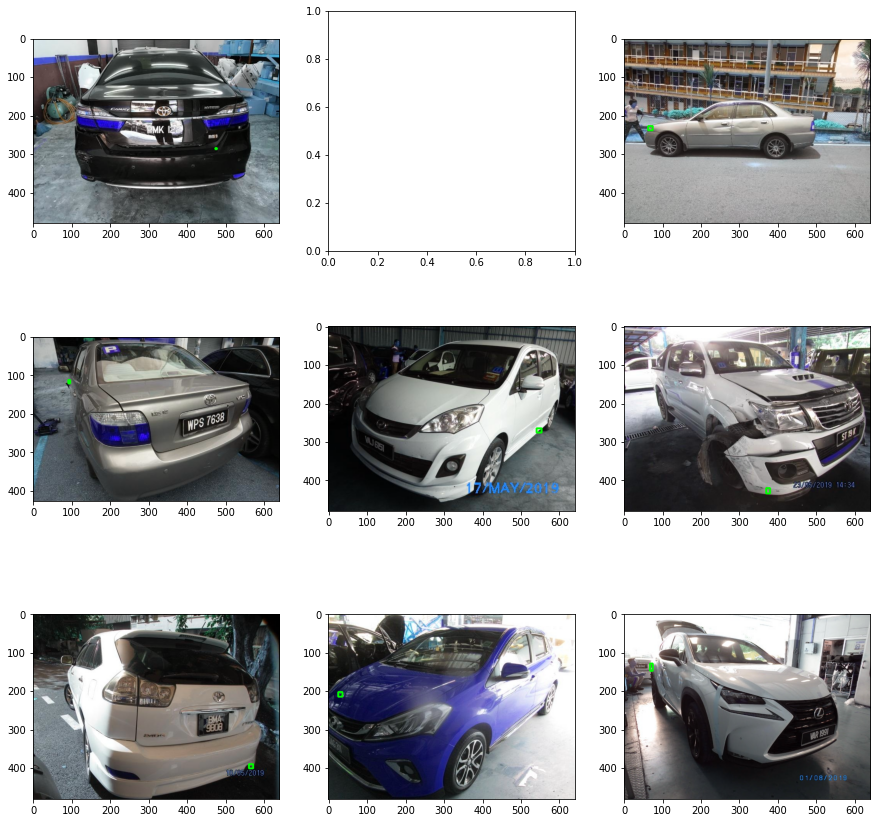

In [157]:
draw_samples(under_lower_ratio_outliers,dent_json, num=3)

In [ ]:
draw_samples(above_upper_ratio_outliers,dent_json, num=3)

### clean data

In [159]:
removed_ann_id = list(under_lower_ratio_outliers.annotation_id)
removed_img_id = list(set(above_upper_ratio_outliers.image_id))

print(len(removed_ann_id), len(removed_img_id))

434 0


In [160]:
new_json = copy.deepcopy(dent_json)

for ann in dent_json['annotations']:
    if ann['image_id'] in removed_img_id:
        removed_ann_id.append(ann['id'])

new_json['images'] = [img for img in dent_json['images'] if img['id'] not in removed_img_id]
new_json['annotations'] = [ann for ann in dent_json['annotations'] if ann['id'] not in removed_ann_id]
print(len(new_json['images']), len(new_json['annotations']))

path = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/clean_dent_annotations.json'

with open(path, 'w', encoding='utf-8') as json_file:
    json.dump(new_json, json_file, ensure_ascii=False, indent=4)

34673 48765


# filtering test set for crack damage

In [38]:
crack_features = features(crack_json)

In [97]:
crack_df = pd.DataFrame({'annotation_id': crack_features.box_area.keys(),
                         'image_id': crack_features.image_id.values(),
                          'box_area': crack_features.box_area.values(),
                          'box_image_ratio': crack_features.box_image_ratio.values()})

crack_df.to_csv('statistical_charts/crack_df.csv', index=False)

In [98]:
crack_df = pd.read_csv('statistical_charts/crack_df.csv')
crack_df

annotation_id  image_id      box_area  box_image_ratio
0                  1         0  19148.501136         0.062332
1                  2         0   4589.377409         0.014939
2                  9         2   6603.292249         0.021495
3                 10         2  19348.520226         0.062983
4                 15         5   3590.645768         0.011688
...              ...       ...           ...              ...
49379         260677     84973    461.175649         0.001501
49380         260679     84975  85752.895569         0.279144
49381         260686     84979    288.607774         0.000939
49382         260698     84980   4104.328205         0.013360
49383         260704     84981   6804.686790         0.022151

[49384 rows x 4 columns]

ratio mean  0.023045542014967155     std  0.05657195926511875
ratio max  0.9911653645833334      ratio min  3.2552083333333334e-11


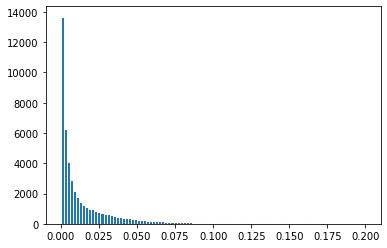

In [161]:
plt.hist(crack_df[crack_df.box_image_ratio<0.2].box_image_ratio, 100, edgecolor='w')
ratio_mean = crack_df.box_image_ratio.mean()
ratio_std = crack_df.box_image_ratio.std()
ratio_min = crack_df.box_image_ratio.min()
ratio_max = crack_df.box_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

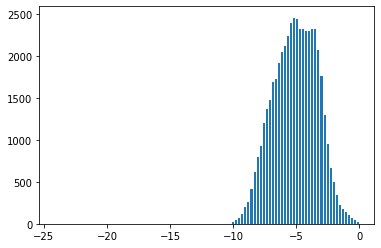

In [100]:
log_ratio = np.log(crack_df.box_image_ratio)
plt.hist(log_ratio,100,edgecolor='w')
print('')

In [162]:
upper_coefficient = (0.1-ratio_mean)/ratio_std

upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = np.exp(-8.5)
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

clean_data = crack_df[(crack_df.box_image_ratio>lower_limit) & (crack_df.box_image_ratio<upper_limit)]
under_lower_ratio_outliers = crack_df[(crack_df.box_image_ratio<=lower_limit)]
above_upper_ratio_outliers = crack_df[(crack_df.box_image_ratio>=upper_limit)]

no_outliers = crack_df.shape[0]-clean_data.shape[0]
print('shape of clean data frame: ', clean_data.shape, '<=>  remove {} outliers'.format(no_outliers))
print('number of lower outliers', under_lower_ratio_outliers.shape[0])

print('number of upper outliers', above_upper_ratio_outliers.shape[0])
print('-----')
print('precentage of total outliers: {:.3f} % annotations'.format((no_outliers/crack_df.shape[0])*100))
print('precentage of tiny outliers: {:.3f} % annotations'.format((under_lower_ratio_outliers.shape[0]/crack_df.shape[0])*100))
print('precentage of huge outliers: {:.3f} % annotations <=> remove {:.3f}% images'.format((above_upper_ratio_outliers.shape[0]/crack_df.shape[0])*100,(above_upper_ratio_outliers.shape[0]/len(crack_json['images']))*100) )

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


upper_limit 0.1
lower_limit 0.00020346836901064417
shape of clean data frame:  (46181, 4) <=>  remove 3203 outliers
number of lower outliers 1160
number of upper outliers 2043
-----
precentage of total outliers: 6.486 % annotations
precentage of tiny outliers: 2.349 % annotations
precentage of huge outliers: 4.137 % annotations <=> remove 6.794% images


(9, 4)


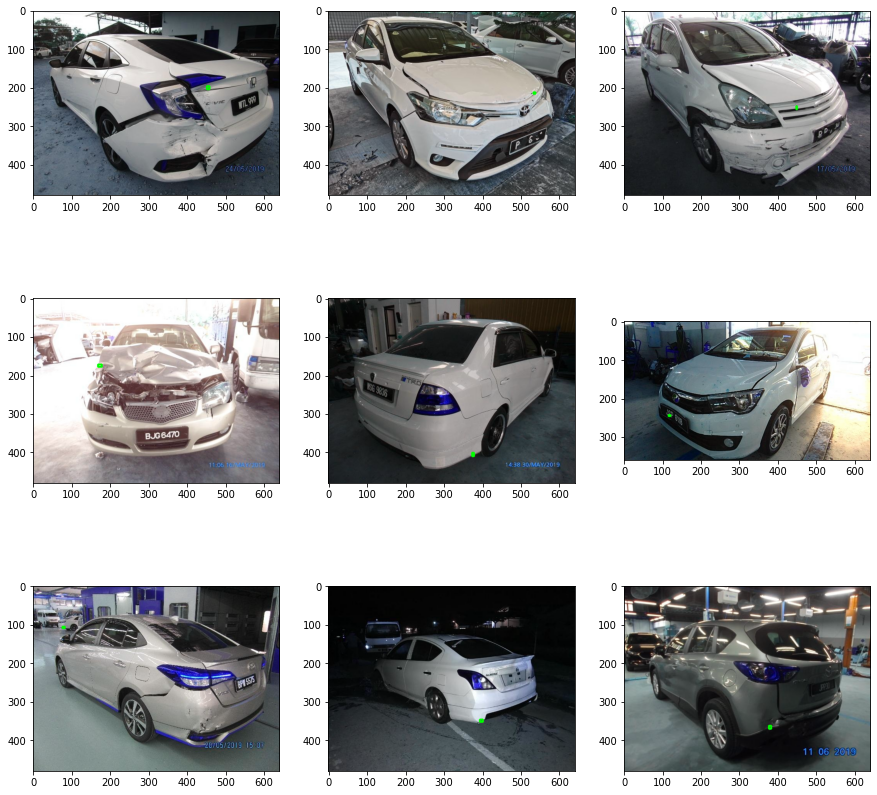

In [163]:
draw_samples(under_lower_ratio_outliers,crack_json, num=3)

(9, 4)


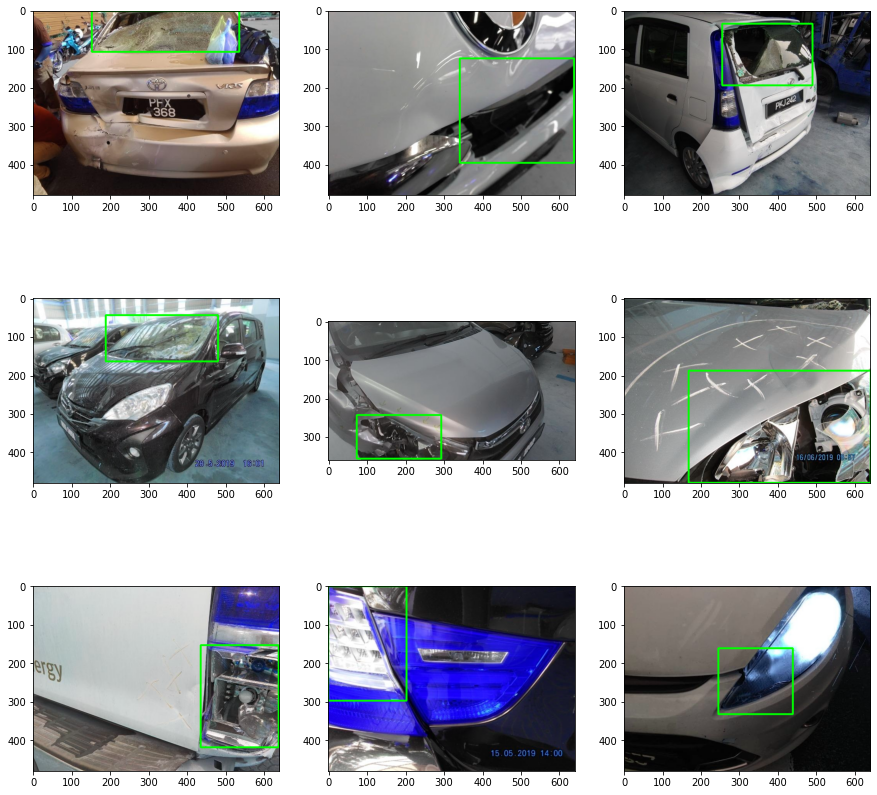

In [164]:
draw_samples(above_upper_ratio_outliers,crack_json, num=3)

### clean data

In [133]:
removed_ann_id = list(under_lower_ratio_outliers.annotation_id)
removed_img_id = list(set(above_upper_ratio_outliers.image_id))

print(len(removed_ann_id), len(removed_img_id))

1160 1990


In [134]:
new_json = copy.deepcopy(crack_json)

for ann in crack_json['annotations']:
    if ann['image_id'] in removed_img_id:
        removed_ann_id.append(ann['id'])

new_json['images'] = [img for img in crack_json['images'] if img['id'] not in removed_img_id]
new_json['annotations'] = [ann for ann in crack_json['annotations'] if ann['id'] not in removed_ann_id]
print(len(new_json['images']), len(new_json['annotations']))

path = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/clean_crack_annotations.json'

with open(path, 'w', encoding='utf-8') as json_file:
    json.dump(new_json, json_file, ensure_ascii=False, indent=4)

28079 45035


# filtering test set for totaled damage

In [42]:
totaled_features = features(totaled_json)

In [104]:
totaled_df = pd.DataFrame({'annotation_id': totaled_features.box_area.keys(),
                           'image_id': totaled_features.image_id.values(),
                          'box_area': totaled_features.box_area.values(),
                          'box_image_ratio': totaled_features.box_image_ratio.values()})

totaled_df.to_csv('statistical_charts/totaled_df.csv', index=False)

In [105]:
totaled_df = pd.read_csv('statistical_charts/totaled_df.csv')
totaled_df

annotation_id  image_id       box_area  box_image_ratio
0                  0         0   80513.377587         0.262088
1                  6         1   43015.906574         0.140026
2                  8         2   76025.593129         0.247479
3                 13         3   85855.000000         0.279476
4                 14         4     793.017025         0.002581
...              ...       ...            ...              ...
46351         260673     84972  248762.898794         0.809775
46352         260678     84974  162931.989221         0.530378
46353         260681     84976   70800.000000         0.230469
46354         260683     84977   14275.873302         0.046471
46355         260684     84978  146863.431481         0.478071

[46356 rows x 4 columns]

ratio mean  0.07930525889365186     std  0.15098054686512594
ratio max  0.996357421875      ratio min  3.2552083333333334e-11


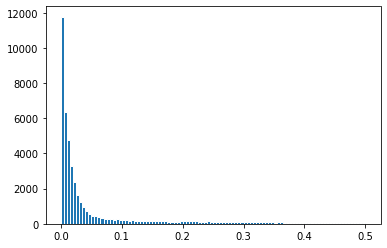

In [166]:
plt.hist(totaled_df[totaled_df.box_image_ratio<0.5].box_image_ratio, 100, edgecolor='w')
ratio_mean = totaled_df.box_image_ratio.mean()
ratio_std = totaled_df.box_image_ratio.std()
ratio_min = totaled_df.box_image_ratio.min()
ratio_max = totaled_df.box_image_ratio.max()
print('ratio mean ', ratio_mean, '    std ', ratio_std)
print('ratio max ', ratio_max, '     ratio min ', ratio_min)

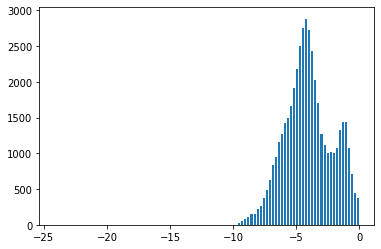

In [107]:
log_ratio = np.log(totaled_df.box_image_ratio)
plt.hist(log_ratio,100,edgecolor='w')
print('')

In [167]:
upper_coefficient = (1-ratio_mean)/ratio_std

upper_limit = ratio_mean + upper_coefficient*ratio_std
lower_limit = np.exp(-10)
print('upper_limit', upper_limit)
print('lower_limit', lower_limit)

clean_data = totaled_df[(totaled_df.box_image_ratio>lower_limit) & (totaled_df.box_image_ratio<upper_limit)]
under_lower_ratio_outliers = totaled_df[(totaled_df.box_image_ratio<=lower_limit)]
above_upper_ratio_outliers = totaled_df[(totaled_df.box_image_ratio>=upper_limit)]

no_outliers = totaled_df.shape[0]-clean_data.shape[0]
print('shape of clean data frame: ', clean_data.shape, '<=>  remove {} outliers'.format(no_outliers))
print('number of lower outliers', under_lower_ratio_outliers.shape[0])

print('number of upper outliers', above_upper_ratio_outliers.shape[0])
print('-----')
print('precentage of total outliers: {:.3f} % annotations'.format((no_outliers/totaled_df.shape[0])*100))
print('precentage of tiny outliers: {:.3f} % annotations'.format((under_lower_ratio_outliers.shape[0]/totaled_df.shape[0])*100))
print('precentage of huge outliers: {:.3f} % annotations <=> remove {:.3f}% images'.format((above_upper_ratio_outliers.shape[0]/totaled_df.shape[0])*100,(above_upper_ratio_outliers.shape[0]/len(totaled_json['images']))*100) )

# n, bins, _ = plt.hist(data_remove_outliers.mask_image_ratio, 100, edgecolor='w')


upper_limit 1.0000000000000002
lower_limit 4.5399929762484854e-05
shape of clean data frame:  (46331, 4) <=>  remove 25 outliers
number of lower outliers 25
number of upper outliers 0
-----
precentage of total outliers: 0.054 % annotations
precentage of tiny outliers: 0.054 % annotations
precentage of huge outliers: 0.000 % annotations <=> remove 0.000% images


(9, 4)


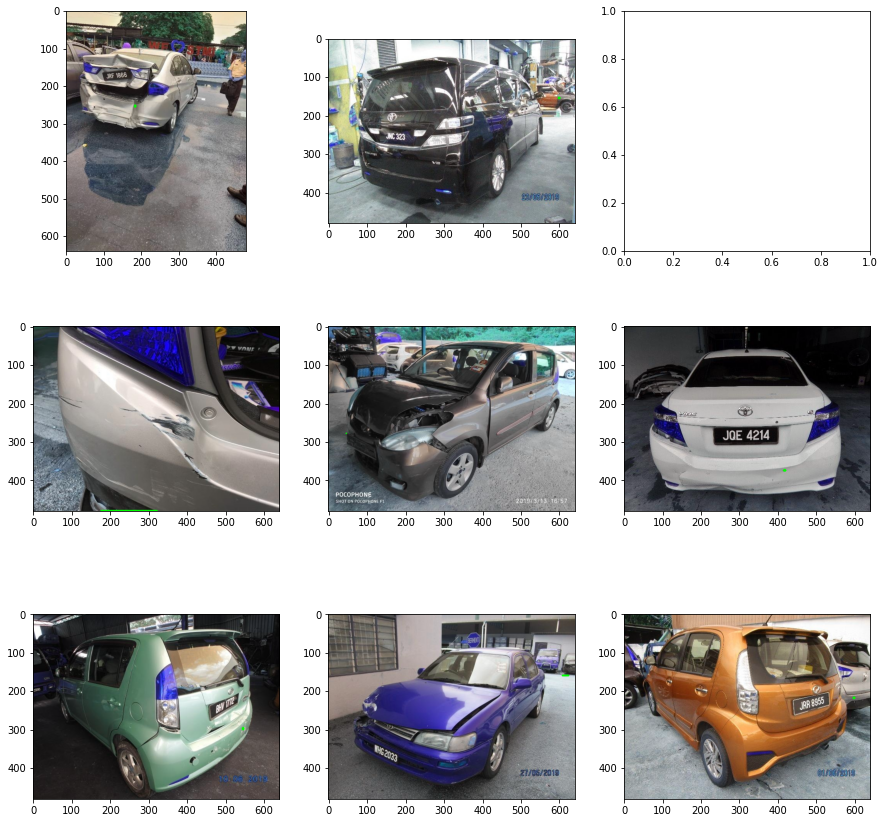

In [168]:
draw_samples(under_lower_ratio_outliers,totaled_json, num=3)

In [ ]:
draw_samples(above_upper_ratio_outliers,totaled_json, num=3)

### clean data

In [169]:
removed_ann_id = list(under_lower_ratio_outliers.annotation_id)
removed_img_id = list(set(above_upper_ratio_outliers.image_id))

print(len(removed_ann_id), len(removed_img_id))

25 0


In [ ]:
new_json = copy.deepcopy(totaled_json)

for ann in totaled_json['annotations']:
    if ann['image_id'] in removed_img_id:
        removed_ann_id.append(ann['id'])

new_json['images'] = [img for img in totaled_json['images'] if img['id'] not in removed_img_id]
new_json['annotations'] = [ann for ann in totaled_json['annotations'] if ann['id'] not in removed_ann_id]
print(len(new_json['images']), len(new_json['annotations']))

path = '../data/coco_datasets/datasets/merimen_coco/06_04_2022/clean_totaled_annotations.json'

with open(path, 'w', encoding='utf-8') as json_file:
    json.dump(new_json, json_file, ensure_ascii=False, indent=4)

34102 46331
